<a href="https://colab.research.google.com/github/aaronkjin/authorship/blob/main/star_wars_authorship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dependencies and Imports

In [ ]:
!pip install -U accelerate
!pip install -U transformers
!pip install evaluate

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split
from collections import Counter
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm
import re

#Dataset

Retrieve data (We used files from Kaggle [[Dataset link]](https://www.kaggle.com/datasets/xvivancos/star-wars-movie-scripts))

In [ ]:
data_paths = ["SW_EpisodeIV.txt", "SW_EpisodeV.txt", "SW_EpisodeVI.txt"]
pattern = '"(.*?)"'

# Function to read and split the dataset
def read_starwars_split(data_paths):
    train_texts = []
    train_labels = []
    label_key = {}
    curr_label_id = -1

    for data_path in data_paths:
        with open(data_path, 'r') as f:
            for line in f.readlines()[1:]:
                s = re.findall(pattern, line)
                id, label, text = int(s[0]), s[1], s[2]
                if label not in label_key:
                    curr_label_id += 1
                    label_key[label] = curr_label_id
                label = label_key[label]
                train_texts.append(text)
                train_labels.append(label)

    return train_texts, train_labels

Split dataset

In [ ]:
# Read and split the dataset
train_texts, train_labels = read_starwars_split(data_paths)

# Count the frequency of each label
label_freq = Counter(train_labels)

# Filter out labels with only one instance
filtered_train_texts = [text for text, label in zip(train_texts, train_labels) if label_freq[label] > 1]
filtered_train_labels = [label for label in train_labels if label_freq[label] > 1]

# Perform train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    filtered_train_texts, filtered_train_labels,
    test_size=0.1,
    random_state=42,
    stratify=filtered_train_labels
)

Tokenize data

In [ ]:
# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Encode texts using the tokenizer
def encode_texts(texts):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)

# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_tensor)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Retrieve model

In [ ]:
# Initialize DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_freq)
)

#Cross Entropy Model

Finetune model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3 - Validation: 100%|██████████| 31/31 [00:11<00:00,  2.73it/s]


Epoch 1/3 - Training Loss: 3.3544, Validation Loss: 2.7949, Duration: 346.79 seconds.


Epoch 2/3 - Validation: 100%|██████████| 31/31 [00:11<00:00,  2.72it/s]


Epoch 2/3 - Training Loss: 2.6244, Validation Loss: 2.4672, Duration: 348.17 seconds.


Epoch 3/3 - Validation: 100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


Epoch 3/3 - Training Loss: 2.1942, Validation Loss: 2.3284, Duration: 346.03 seconds.


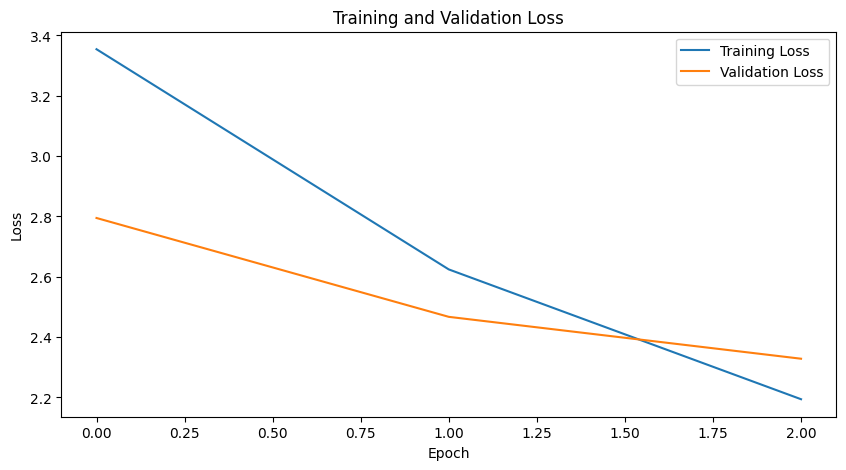

In [ ]:
# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 3
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    start_time = time()

    # Training loop
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    duration = time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Duration: {duration:.2f} seconds.")

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


#Hinge Loss Model

In [ ]:
class CustomHingeLoss(torch.nn.Module):
    def __init__(self):
        super(CustomHingeLoss, self).__init__()

    def forward(self, outputs, labels):
        # Assuming outputs are raw scores (logits) and labels are indices of the correct class
        correct_scores = outputs[range(len(outputs)), labels].unsqueeze(1)  # shape (N, 1)
        margin = 1.0  # You can adjust the margin
        loss = torch.mean(torch.clamp(1 - correct_scores + outputs, min=0))  # hinge loss
        return loss

loss_fn = CustomHingeLoss()

# Initialize DistilBERT model for sequence classification
HingeLossModel = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_freq)
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3 - Validation: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Epoch 1/3 - Training Loss: 0.2954, Validation Loss: 0.1460, Duration: 497.17 seconds.


Epoch 2/3 - Validation: 100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Epoch 2/3 - Training Loss: 0.1517, Validation Loss: 0.1148, Duration: 485.58 seconds.


Epoch 3/3 - Validation: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]


Epoch 3/3 - Training Loss: 0.1186, Validation Loss: 0.1043, Duration: 488.86 seconds.


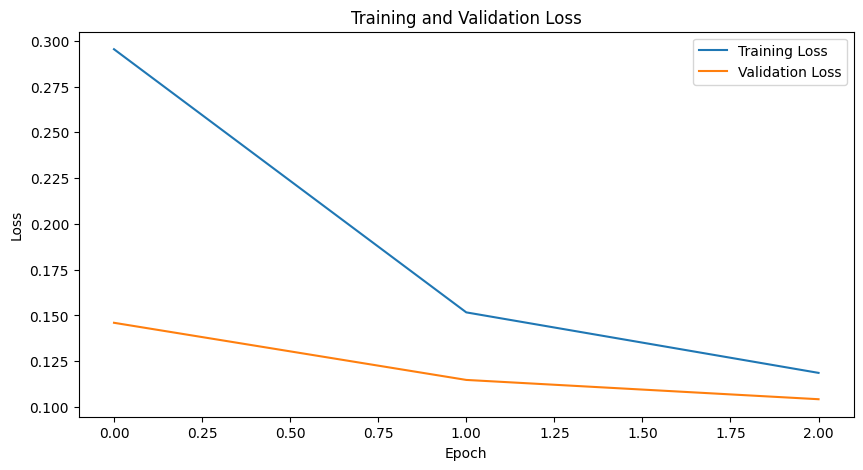

In [ ]:
# Define optimizer and loss function
optimizer = AdamW(HingeLossModel.parameters(), lr=2e-5)
loss_fn = CustomHingeLoss()

# Training loop
num_epochs = 3
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    start_time = time()

    # Training loop
    HingeLossModel.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = HingeLossModel(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    HingeLossModel.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            input_ids, attention_mask, labels = batch
            outputs = HingeLossModel(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    duration = time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Duration: {duration:.2f} seconds.")

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


In [ ]:
from transformers import DistilBertForSequenceClassification

num_labels = len(set(train_labels))  # Number of unique labels
base_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def predict(base_model, dataloader):
    base_model.eval()
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch[0].to(base_model.device)
            attention_mask = batch[1].to(base_model.device)
            outputs = base_model(input_ids=input_ids, attention_mask=attention_mask)
            pred_labels = torch.argmax(outputs.logits, dim=1)
            predictions.extend(pred_labels.cpu().numpy())
    return predictions

In [ ]:
train_predictions = predict(base_model, train_loader)
val_predictions = predict(base_model, val_loader)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

train_accuracy = accuracy_score(train_labels, train_predictions)
val_accuracy = accuracy_score(val_labels, val_predictions)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

# You can also use classification_report for more detailed metrics
print("Training Classification Report:")
print(classification_report(train_labels, train_predictions))

print("Validation Classification Report:")
print(classification_report(val_labels, val_predictions))
